# Model without LSTM nor Attention

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from T01_prototype.S00_utils import loadPickle, plot_res, store_results
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from T03.models import MyModel_Min as MyModel

torch.Size([6, 3])
torch.Size([6, 53, 2, 53])


In [4]:
df = pd.read_excel("../T01_prototype/output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [5]:
colsY = ["y1", "y2", "y3"]
# colsX = [c for c in df.columns if c not in colsY]
colsX = ["m1", "m2", "m3"]

dfX = df[colsX]
dfY = df[colsY]

In [6]:
dfData = loadPickle("../T01_prototype/output/S11__2025-04-21-052441.pickle")

In [7]:
dfData
tsArr = [t[1] for t in dfData["ts"].values]

In [8]:
# Max length
maxTime = 0
for ts in tsArr:
    maxTime = len(ts) if maxTime < len(ts) else maxTime

print(maxTime)

298


(100, 20, 2)


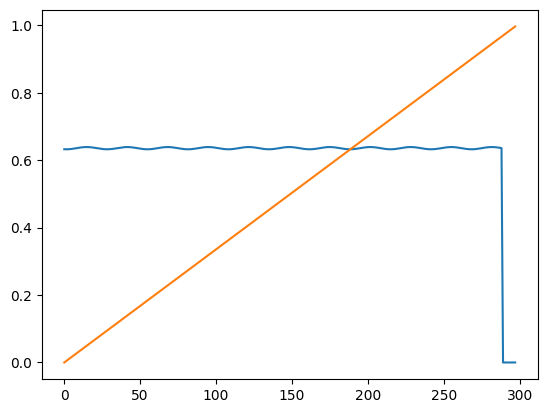

In [9]:
# Scaling and Padding
# TODO: Needs to only calculate mean, std, min, max from training example.

SCALING_TYPE = "Min_Max"
# SCALING_TYPE = "STANDARDIZATION"

tsArrConcat = np.concatenate(tsArr)
if SCALING_TYPE == "STANDARDIZATION":
    meanVal = np.mean(tsArrConcat)
    stdVal = np.std(tsArrConcat)
elif SCALING_TYPE == "Min_Max":
    maxVal = np.max(tsArrConcat)
    minVal = np.min(tsArrConcat)

# Shape = (Batch, Time, Features)
TsData_std = np.zeros((dfData.shape[0], maxTime, 2))
for idx, ts in enumerate(tsArr):
    if SCALING_TYPE == "STANDARDIZATION":
        ts_std = (ts - meanVal) / stdVal
    elif SCALING_TYPE == "Min_Max":
        ts_std = (ts - minVal) / (maxVal - minVal)

    TsData_std[idx, : len(ts), 0] = ts_std  # Scaling
    TsData_std[idx, len(ts) :, 0] = 0  # Padding

    # Add time index (scaled)
    TsData_std[idx, :, 1] = np.arange(maxTime) / maxTime  # Time index
plt.plot(TsData_std[0, :, 0])
plt.plot(TsData_std[0, :, 1])

# TRUNCATION
TsData_std = TsData_std[:, :20, :]

print(TsData_std.shape)

In [10]:
# Find the ending time for each time series
et_arr = [float(t[0][-1]) for t in dfData["ts"].values]
num_output = dfY.shape[1]
tsEndTimes = np.zeros((dfData.shape[0], dfY.shape[1], 1))
for idx, et in enumerate(et_arr):
    for t in range(num_output):
        tsEndTimes[idx, t, 0] = (et + t) / maxTime

In [11]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0, test_size=0.30)
idxs = np.arange(df.shape[0])
idxTrain, idxTest = next(cv.split(X=idxs))
print(idxTrain)
print(idxTest)

[60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40 38  5 91 59  0 34
 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29 49 97 98 69 20 94
 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76]


In [12]:
dfX_train = dfX.iloc[idxTrain, :]
dfX_test = dfX.iloc[idxTest, :]
dfY_train = dfY.iloc[idxTrain, :]
dfY_test = dfY.iloc[idxTest, :]
Ts_train_std = TsData_std[idxTrain, :]
Ts_test_std = TsData_std[idxTest, :]
Fu_train_std = tsEndTimes[idxTrain, :]
Fu_test_std = tsEndTimes[idxTest, :]

In [13]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(dfX_train)
X_test_std = scX.transform(dfX_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(dfY_train)
Y_test_std = scY.transform(dfY_test)

In [14]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)
Ts_train_std = torch.tensor(Ts_train_std, dtype=torch.float32)
Ts_test_std = torch.tensor(Ts_test_std, dtype=torch.float32)
Fu_train_std = torch.tensor(Fu_train_std, dtype=torch.float32)
Fu_test_std = torch.tensor(Fu_test_std, dtype=torch.float32)

In [15]:
tab_num_features = dfX.shape[1]
ts_embedding_size = 8
ts_num_features = Ts_train_std.shape[-1]
lstm_num_layers = 2
lstm_dropout = 0.5
attn_n_head = 1
num_output = Y_test_std.shape[1]

# Initialize model
model = MyModel(
    tab_num_features=tab_num_features,
    ts_embedding_size=ts_embedding_size,
    ts_num_features=ts_num_features,
    lstm_num_layers=lstm_num_layers,
    num_output=num_output,
)

In [16]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

0 0.14311112463474274
1 0.09135524183511734
2 0.07331623136997223
3 0.05123504623770714
4 0.05321751534938812
5 0.05129912868142128
6 0.05042135342955589
7 0.0503736212849617
8 0.050119347870349884
9 0.04978509992361069
10 0.049682993441820145
11 0.049581047147512436
12 0.04951924830675125
13 0.04953889921307564
14 0.04954131320118904
15 0.04954519122838974
16 0.04953833296895027
17 0.04953130707144737
18 0.049513667821884155
19 0.04949909821152687
20 0.04949512332677841
21 0.04949375241994858
22 0.049473199993371964
23 0.049456845968961716
24 0.04944903030991554
25 0.049424197524785995
26 0.04940040782094002
27 0.04936790093779564
28 0.049332354217767715
29 0.04928753152489662
30 0.049208901822566986
31 0.04909443482756615
32 0.048943229019641876
33 0.04860178753733635
34 0.04800793156027794
35 0.046797096729278564
36 0.0449739545583725
37 0.043209467083215714
38 0.042631134390830994
39 0.04282854497432709
40 0.04329274594783783
41 0.04460952430963516
42 0.045591872185468674
43 0.0458

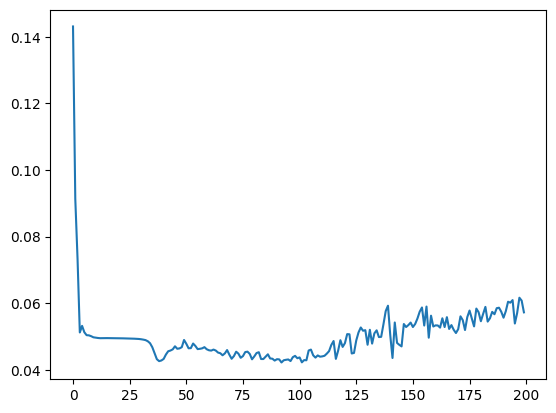

In [17]:
n_epochs = 200
# number of epochs to run
batch_size = 5  # size of each batch
batch_start = torch.arange(0, len(X_train_std), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_tab_batch = X_train_std[start : start + batch_size]
            x_ts_batch = Ts_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            x_future = Fu_train_std[start : start + batch_size]
            # forward pass
            y_pred, _ = model(
                x_tab=x_tab_batch,
                x_ts=x_ts_batch,
                x_future=x_future,
            )
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred, _ = model(x_ts=Ts_test_std, x_tab=X_test_std, x_future=Fu_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

    print(epoch, mse)
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [18]:
model.eval()
Y_train_pred, attn_train = model(
    x_ts=Ts_train_std,
    x_tab=X_train_std,
    x_future=Fu_train_std,
)
Y_test_pred, attn_test = model(
    x_ts=Ts_test_std,
    x_tab=X_test_std,
    x_future=Fu_test_std,
)

In [19]:
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

In [20]:
if not isinstance(Y_train_std, np.ndarray):
    Y_train_std = Y_train_std.detach().numpy()
    Y_test_std = Y_test_std.detach().numpy()


,MSE Train,MSE Test,R2 Train,R2 Test
0,0.037315,0.047915,0.167339,0.105979
1,0.024059,0.035027,0.373527,-0.132978
2,0.026290,0.043740,0.552868,0.165440


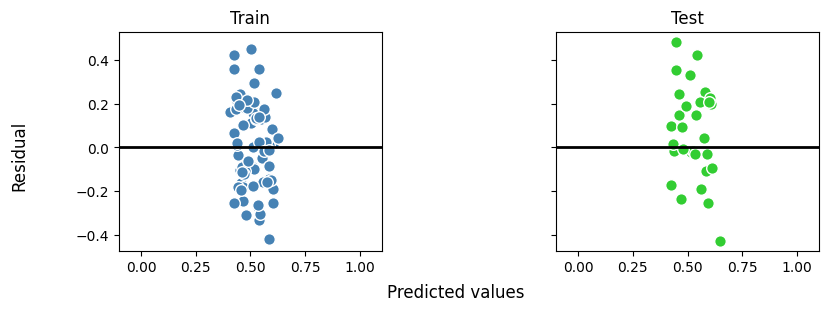

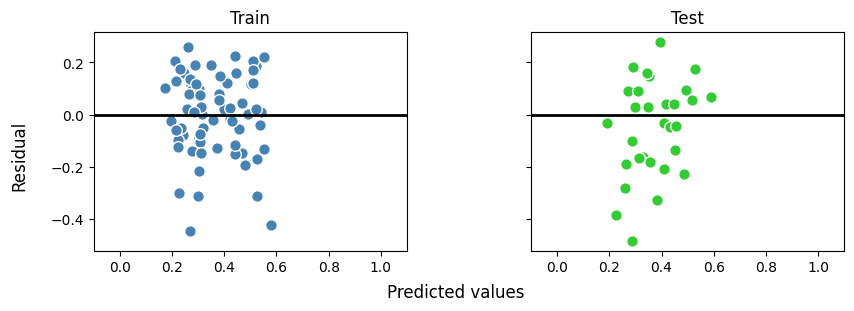

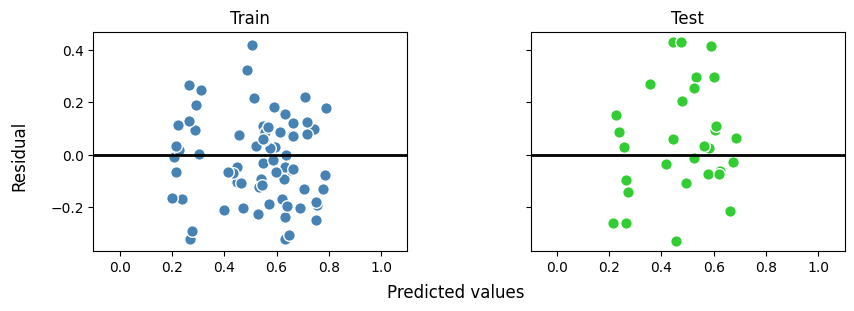

In [21]:
resArr = []
for i in range(dfY.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes

In [22]:
att = attn_train.detach().numpy()
print(att.shape)

(70, 3)
